Automatically analyse all data-files in a dataset
=======

Import the required bits.

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import mindaffectBCI.decoder.offline.datasets as datasets
from mindaffectBCI.decoder.decodingCurveSupervised import decodingCurveSupervised, print_decoding_curve, plot_decoding_curve
from mindaffectBCI.decoder.analyse_datasets import decoding_curve_GridSearchCV, datasets_decoding_curve_GridSearchCV, average_results_per_config, plot_decoding_curves
from mindaffectBCI.decoder.preprocess_transforms import make_preprocess_pipeline, ClassAveragePlotter
from mindaffectBCI.decoder.utils import askloadsavefile

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures

Analyse all datafiles in a single dataset with given analysis settings
-----


### Tell the system the directory where the datasets directory is located

In [2]:
# tell the system where the data is stored..
#datasets.add_dataroot('')
datasets.set_dataroot('D://')
datasets.get_dataroot()

'D://'

## set the dataset you want and get the list of files in it.
* `dataset` is parent directory name, relative to dataroot, to search for datasets
* `label` is human readable label for this dataset+analysis for plots etc.

In [ ]:
# Lowlands
dataset='lowlands'
dataset_args=dict()
label='lowlands'

In [3]:
# plos_one
dataset='plos_one'
dataset_args=dict()
label='plos_one'

In [2]:
# ask for a directory to load
dataset='mindaffectBCI'
dataset_args=dict(exptdir=askloadsavefile(filetypes='dir'))

## get the list of datasets and the loader object

In [3]:
loader,filenames,_ = datasets.get_dataset(dataset, **dataset_args)
cp = os.path.commonprefix(filenames)
labels = [ p[len(cp):] for p in filenames ]
print("{} has {} files\n{}".format(dataset,len(filenames),"\n".join(labels)))

mindaffectBCI has 74 files
201029_1340_ganglion.txt
201029_1350_ganglion.txt
201029_1356_ganglion.txt
201029_1403_ganglion.txt
201029_1418_ganglion.txt
201029_1425_ganglion.txt
201029_1434_ganglion.txt
201029_1443_ganglion.txt
201102_1313_ganglion.txt
201102_1319_ganglion.txt
201102_1326_ganglion.txt
201102_1331_ganglion.txt
201102_1337_ganglion.txt
201109_1405_calibrate.txt
201109_1413_restart_predonly.txt
201109_1423_restart_predonly.txt
201109_1440_refit_predonly.txt
201109_1619_refit_predonly.txt
201111_1625_kit20.txt
201111_1631_kit20.txt
201111_1641_ipad.txt
201111_1650_ipad2python.txt
201112_1531_linux.txt
201112_1541_linux.txt
201112_1547_linux.txt
201112_1548_windows.txt
201112_1552_windows.txt
201112_1555_linux.txt
201112_1559_linux.txt
201112_1609_linux.txt
201117_1156.txt
201117_1204.txt
201117_1451_falseseln.txt
201117_1457_falseseln.txt
201117_1503_falseseln.txt
201117_1510_falseseln.txt
201120_1117_cyton_python.txt
201120_1122_cyton_python.txt
201203_1453.txt
201203_1505

## Fit model to each of the datasets

## Specify the analysis pipeline you want to use.
The pipeline is given as a list of 'stages' which will be processed in turn by calling the appropriate class's `fit` and `modify` methods.   See `decoder/preprocess_transforms.py` for a list of available transforms.

Here we use:
  * `MetaInfoAdder` : to attach important meta-info, specifically the data samplerate and the list of channel names. 
  * `ButterFilterAndResampler` : To use a 'butterworth' IIR filter to first spectrally filter the data and then downsample it to a new sample rate
  * `MultiCCA` : This is the Cannonical Correlation Analysis based Sequence2Sequence classifier we use for the analysis.  For more information on the available Sequence2Sequence classifiers available see `decoder/model_fitting.py`


In [4]:
# Single Cell version: all fixed!

# default pipeline
fs_out = 180
loader_args={'fs_out':fs_out,'filterband':((0,1),(45,65),(95,105),(145,155),(195,205))}#,'sample2timestamp':'lower_bound_tracker'}#'robust_timestamp_regression'}# 
pipeline=[
    ['MetaInfoAdder',{'info':{'fs':-1}}],
    ['ButterFilterAndResampler',{'filterband':[(3,25,'bandpass')], 'fs_out':fs_out}],
    #['TargetEncoder',{'evtlabs':('re','fe')}],
    ['MultiCCACV:clsfr',{'tau_ms':450, 'offset_ms':0,'evtlabs':('onset','offset'), 'temporal_basis':'fourier2,8'}], #
    #['BwdLinearRegressionCV:clsfr',{"tau_ms":450, "inner_cv_params":{"reg":(1e-4, 1e-3, .01, .1, .5, 1-.1, 1-.01)}}]
    #['MultiCCA:clsfr',{'tau_ms':450, 'offset_ms':0}]
]
ppp = make_preprocess_pipeline(pipeline)
print(ppp)

PreprocessPipeline(stages=[('metainfoadder', MetaInfoAdder(info={'fs': -1})),
                           ('butterfilterandresampler',
                            ButterFilterAndResampler(filterband=[(3, 25,
                                                                  'bandpass')],
                                                     fs_out=180)),
                           ('clsfr',
                            MultiCCACV(evtlabs=('onset', 'offset'), tau_ms=450,
                                       temporal_basis='fourier2,8'))])


## Test: run a single dataset with this pipeline
By:
1. Loading the data
2. Visualizing the data, via. and ERP plot
2. Making the analysis pipeline
3. Fit the pipeline to the data
4. Assessing the fitted model quality

Note: you can access the created or fitted data transformation 'stages' through the `stages` property of the created pipeline.

In [5]:
# 1. Load the data, extract meta-info
X_TSd, Y_TSy, coords = loader(filenames[0],**loader_args)
fs=coords[1]['fs']
ch_names=coords[2]['coords']


X=(101926, 4) @200.0Hz
preFilter: 6th butter [(0, 1), (45, 65), (95, 105), (145, 155), (195, 205), (81.0, -1)]Hz & downsample 200.0->180Hz
resample: 200.0->200.0hz rsrate=1.0
Y=(101926, 26) @200.0Hz
slicing 40 trials =[-400 - 1291] samples @ 200.0Hz


[22445]


EventRelatedPotentialPlotter(fig=<Figure size 864x576 with 4 Axes>, tau_ms=600)

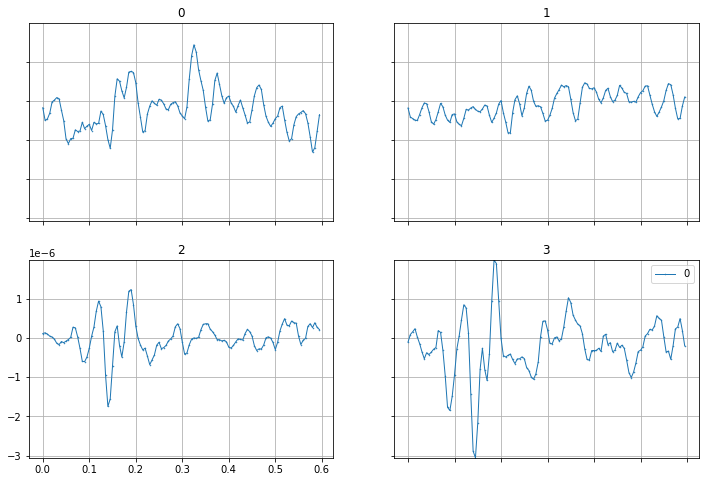

In [6]:
# plot the average response when the stimulus is high, to give idea of the signal2noise
ClassAveragePlotter(tau_ms=600).fit(X_TSd, Y_TSy, fs=fs, ch_names=ch_names)

141/2920 artifacts
Plot Factored Model
A=(1, 4) R=(1, 2, 90)
trying to get pos from cap file!


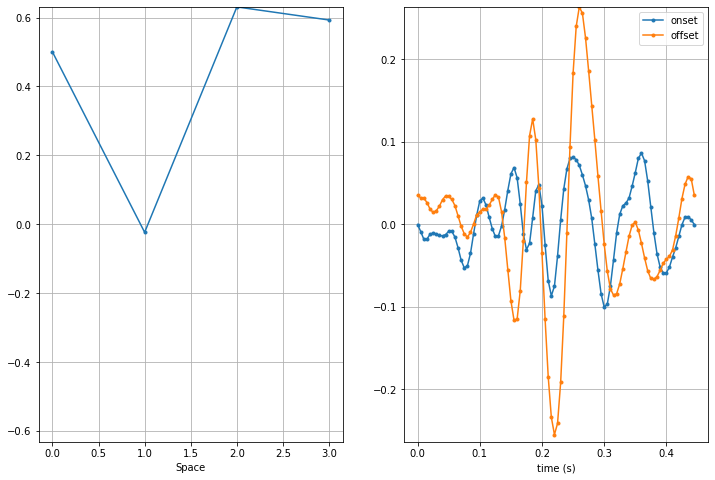

In [8]:
# 2. Make the analysis pipeline -- after updating the metainfo adder to reflect the data properties
pipeline[0][1]['info'] = {'fs':fs,'ch_names':ch_names}
ppp = make_preprocess_pipeline(pipeline)
# 3. Fit the pipeline to the data
ppp.fit(X_TSd,Y_TSy)
# 4. plot the fitted classifier model, i.e. last stage
ppp.stages[-1][1].plot_model(fs=fs,ch_names=ch_names)


     -> best={},1 = 0.435
 Retraining on all data with: rank=1 reg=(1e-08, 1e-08)
Int Lens:..............................

            IntLen   225   450   620   845  1070  1240  1465  1691 
              Perr  0.95  0.93  0.72  0.45  0.35  0.28  0.28  0.28   AUDC 55.4
         Perr(est)  0.98  0.52  0.36  0.28  0.21  0.17  0.16  0.16   PSAE 56.0
           StopErr  0.90  0.93  0.72  0.53  0.35  0.35  0.35  0.35   AUSC 58.2
     StopThresh(P)  0.63  0.52  0.21  0.13  0.10  0.10  0.10  0.10   SSAE 202.7



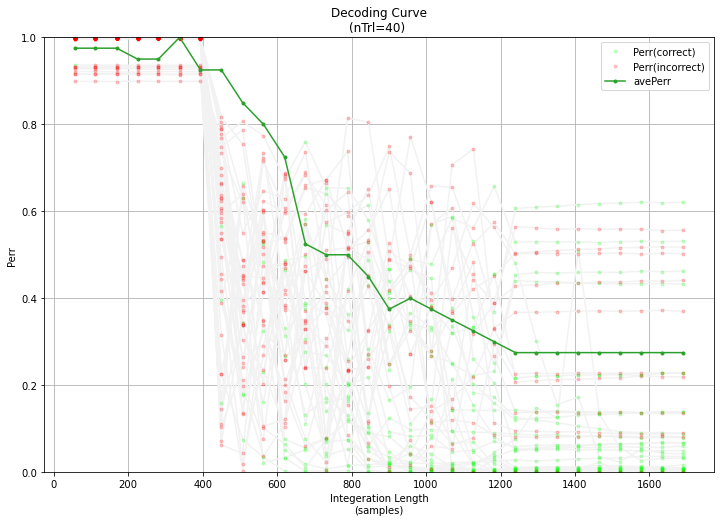

In [9]:
# 4. Assess the fitted model performance.   
#    As we want a cv'd estimate of the classifier performance we do this in 3 stages,
#    a) we apply the fitted model before the classifier to the data
Xpp_TSd, Ypp_TSye = ppp.modify(X_TSd,Y_TSy,until_stage=-1)
#    b) then we cv apply the classifer to get a cv'd classifier prediction
res = ppp.stages[-1][1].cv_fit(Xpp_TSd, Ypp_TSye)
#    c) then we assess the performance of these cv'd predictions
plot_decoding_curve( *decodingCurveSupervised(res['estimator']))

## Now do the same for all data-sets together and collate the results to a final performance

So far we have just run the analysis on a single, previously loaded dataset.  However, to get a real feeling for the importance of different settings, we need to compare them over multiple files recorded at different times for different subjects.  

To make this easier to perform, a equivalent function called `datasets_decoding_curve_GridsearchCV` is provided for running a GridsearchCV over multiple data sets.

To use this function, you must provide a file-loader function and a set of file-names to process, for example as produced as the output of the `get_dataset` call use above.

To run the decoding curve analysis on all the datasets we got above, with the same pipeline we used for the single data-set test.

In [15]:
# run the model fit
# first make the base pipeline to run
ppp = make_preprocess_pipeline(pipeline)

# run this pipeline with all the settings.
# N.B. set n_jobs=1 for pipeline debugging as it gives more informative error messages and stops at first error
res = datasets_decoding_curve_GridSearchCV(ppp,filenames, loader, loader_args=loader_args, 
                                           cv=[(slice(10),slice(10,None))], n_jobs=4, 
                                           cv_clsfr_only=False)


print("Ave-DC")
print(print_decoding_curve(*(average_results_per_config(res)['decoding_curve'][0])))

plt.figure()
plot_decoding_curves(res['decoding_curve'],labels=res['filename'])
plt.show(block=True)

Running with 4 parallel tasks, one-per-filename
Submitting {} jobs:..........................................................................74 jobs submitted in    0s. Waiting results.

1% 1 / 74 collected in 10.5s  est 773.7s total 763.3s remaining
5% 4 / 74 collected in 52.8s  est 977.7s total 924.8s remaining
12% 9 / 74 collected in 56.3s  est 463.0s total 406.7s remaining
16% 12 / 74 collected in 59.7s  est 368.1s total 308.4s remaining
21% 16 / 74 collected in 62.9s  est 291.1s total 228.2s remaining
32% 24 / 74 collected in 66.0s  est 203.6s total 137.6s remaining
33% 25 / 74 collected in 109.0s  est 322.6s total 213.6s remaining
40% 30 / 74 collected in 112.1s  est 276.4s total 164.4s remaining
45% 34 / 74 collected in 115.4s  est 251.2s total 135.8s remaining
52% 39 / 74 collected in 120.3s  est 228.3s total 108.0s remaining
58% 43 / 74 collected in 124.1s  est 213.5s total 89.5s remaining
64% 48 / 74 collected in 127.6s  est 196.7s total 69.1s remaining
68% 51 / 74 collected 

This time, the results contains a set of keys with lists as values.  In this case each entry in the value list is a single run _of a particular configuration on a particular file name_.  As we want to see how a config does over all file names we first average over file-name to summarise the results.

In [ ]:
# raw results are per run, i.e. combination of filename and configuration
# interested in effect of config, so average over filenames to get a pre-configuration summary
res = average_results_per_config(res)

As we now have 'row-per-config' we can plot the decoding curves as for a single file:

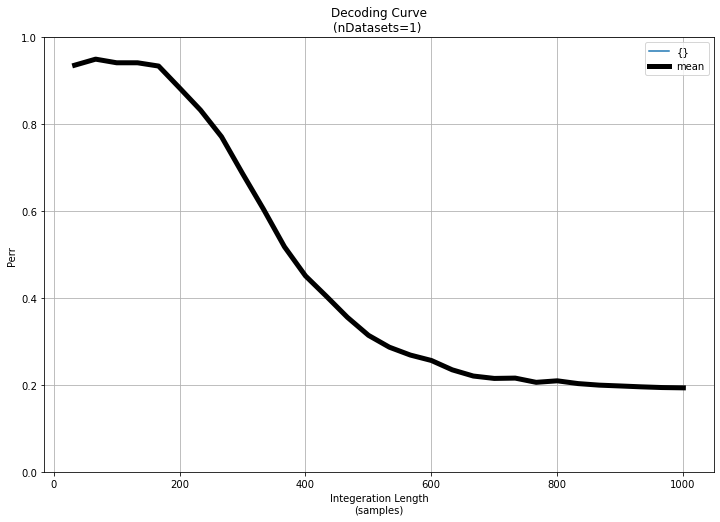



{}

            IntLen   133   266   366   500   633   733   867  1000 
              Perr  0.94  0.77  0.52  0.31  0.24  0.22  0.20  0.19   AUDC 46.1
         Perr(est)  0.93  0.54  0.31  0.23  0.19  0.18  0.17  0.17   PSAE 30.6
           StopErr  0.91  0.74  0.57  0.42  0.34  0.33  0.33  0.33   AUSC 52.6
     StopThresh(P)  0.65  0.33  0.19  0.14  0.14  0.14  0.14  0.14   SSAE 130.7



In [ ]:
plt.figure()
plot_decoding_curves(res['decoding_curve'],labels=res['config'])
plt.show(block=True)

for si in np.argsort(res['audc']):
    dc,conf = (res['decoding_curve'][si],res['config'][si])
    print("\n\n{}\n".format(conf))
    print(print_decoding_curve(*dc))

We can also print the full pre-filename decoding curve information for for through investigation

In [14]:
for r,f in zip(res['decoding_curve'],res['filename']):
    print(f)
    print(print_decoding_curve(*r))

mindaffectBCI_noisetag_bci_201029_1340_ganglion.txt
            IntLen   225   450   620   845  1070  1240  1465  1691 
              Perr  1.00  0.90  0.77  0.67  0.60  0.57  0.57  0.57   AUDC 72.1
         Perr(est)  0.98  0.55  0.36  0.41  0.39  0.36  0.37  0.38   PSAE 49.2
           StopErr  0.90  0.90  0.90  0.90  0.80  0.70  0.68  0.68   AUSC 82.6
     StopThresh(P)  0.77  0.77  0.77  0.49  0.40  0.44  0.49  0.49   SSAE 45.2

mindaffectBCI_noisetag_bci_201029_1350_ganglion.txt
            IntLen   219   438   602   822  1041  1205  1424  1644 
              Perr  0.95  1.00  0.95  0.70  0.50  0.40  0.40  0.40   AUDC 68.2
         Perr(est)  0.97  0.53  0.44  0.33  0.36  0.29  0.25  0.27   PSAE 55.9
           StopErr  1.00  1.00  1.00  1.00  0.87  0.73  0.63  0.63   AUSC 87.1
     StopThresh(P)  0.81  0.81  0.81  0.71  0.50  0.46  0.46  0.46   SSAE 40.1

mindaffectBCI_noisetag_bci_201029_1356_ganglion.txt
            IntLen   260   520   715   975  1235  1430  1690  1951 
      

# Run different parameter settings and compare final performance
Now let's see the effect of varying some of the 'hyperparameters' of the pipeline

specify the `tuned_parameters` grid to evaluate.

**N.B. each field should contain a list of valid parameter settings**

In [11]:
tuned_parameters=dict()
#tuned_parameters['clsfr__evtlabs']=[('re','fe'),('re','fe','anyfe')]
tuned_parameters['clsfr__tau_ms']=[350,450]
#tuned_parameters['clsfr__offset_ms']=[0,100]
tuned_parameters['clsfr__temporal_basis']=['none','winfourier1,10','winfourier2,10','winfourier2,15']

Now run the cross dataset analysis.    **This may take some time**   To speed things up a bit we specify `n_jobs=4` to run 4 analysis in parallel threads. (Note: don't set  `n_jobs` too high as that can cause job failures due to memory constraints.  Also for debugging run with `n_jobs=1` as this gives more informative error messages.)

At the end you will get a textual summary of the results, and the detailed results are returned.

In [12]:
ppp = make_preprocess_pipeline(pipeline)
# run this pipeline with all the settings.
# N.B. set n_jobs=1 for pipeline debugging as it gives more informative error messages and stops at first error
res = datasets_decoding_curve_GridSearchCV(ppp,filenames, loader, loader_args=loader_args, 
                                           cv=[(slice(10),slice(10,None))], n_jobs=4, 
                                           cv_clsfr_only=False, tuned_parameters=tuned_parameters)

Running with 4 parallel tasks, one-per-filename
Submitting {} jobs:............12 jobs submitted in    0s. Waiting results.

8% 1 / 12 collected in 34.7s  est 416.6s total 381.9s remaining
16% 2 / 12 collected in 47.7s  est 286.4s total 238.7s remaining
25% 3 / 12 collected in 55.0s  est 220.1s total 165.1s remaining
33% 4 / 12 collected in 69.0s  est 206.9s total 137.9s remaining
41% 5 / 12 collected in 82.8s  est 198.8s total 116.0s remaining
50% 6 / 12 collected in 88.9s  est 177.9s total 88.9s remaining
58% 7 / 12 collected in 134.4s  est 230.3s total 96.0s remaining
66% 8 / 12 collected in 141.3s  est 211.9s total 70.6s remaining
75% 9 / 12 collected in 212.6s  est 283.5s total 70.9s remaining
91% 11 / 12 collected in 216.0s  est 235.6s total 19.6s remaining
100% 12 / 12 collected in 325.1s  est 325.1s total  0.0s remaining


### Visualize the reslts

Ave-DC


{'clsfr__tau_ms': 350, 'clsfr__temporal_basis': 'none'}

            IntLen   201   403   554   756   957  1108  1310  1512 
              Perr  0.67  0.44  0.35  0.29  0.26  0.22  0.21  0.21   AUDC 36.8
         Perr(est)  0.53  0.37  0.30  0.26  0.22  0.19  0.17  0.16   PSAE 22.2
           StopErr  0.96  0.96  0.77  0.56  0.47  0.44  0.44  0.44   AUSC 65.4
     StopThresh(P)  0.72  0.72  0.53  0.40  0.37  0.38  0.38  0.38   SSAE 28.4



{'clsfr__tau_ms': 350, 'clsfr__temporal_basis': 'winfourier1,10'}

            IntLen   201   403   554   756   957  1108  1310  1512 
              Perr  0.71  0.46  0.39  0.33  0.29  0.24  0.23  0.22   AUDC 39.9
         Perr(est)  0.54  0.38  0.32  0.27  0.24  0.21  0.19  0.19   PSAE 25.7
           StopErr  0.95  0.95  0.78  0.58  0.49  0.48  0.45  0.45   AUSC 66.5
     StopThresh(P)  0.73  0.73  0.55  0.41  0.38  0.39  0.40  0.40   SSAE 28.4



{'clsfr__tau_ms': 350, 'clsfr__temporal_basis': 'winfourier2,10'}

            IntLen   201  

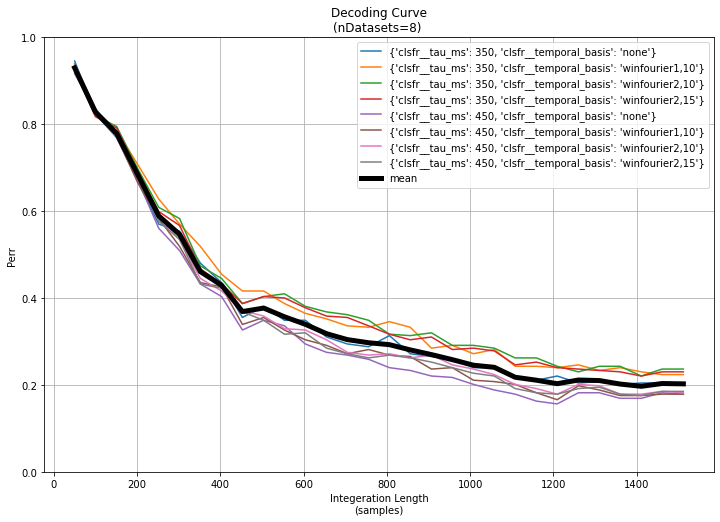

In [ ]:
# average the results over data-files for each pipeline configuration
averes = average_results_per_config(res)

print("Ave-DC")
# report the per-config summary
for dc,conf in zip(averes['decoding_curve'],averes['config']):
    print("\n\n{}\n".format(conf))
    print(print_decoding_curve(*dc))

plot_decoding_curves(averes['decoding_curve'],labels=res['config'])
plt.show(block=True)